In [3]:
%load_ext autoreload
%autoreload 2
from openAIgym.two_wheel_robot import TwoWheelRobot

env = TwoWheelRobot()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
env.reset()
env.render()

In [1]:
while True:
  env.render()

NameError: name 'env' is not defined

In [87]:
obs = env.step((-.5,-.5))
env.render()
obs

(array([-2.39825297e-02,  9.99766404e-01,  1.05429901e-05,  1.06452555e-02,
        -1.88099941e-02, -7.92695018e+00, -7.93675497e+00, -1.42188970e-02,
         1.37223316e-03, -1.23013266e-01,  1.74694576e-02,  5.48593901e-01,
         1.06608310e-03, -1.68751020e+01, -1.68588133e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.26150160e-02,  7.85537061e-01, -2.60782074e-02,
         1.00000000e+00, -8.48353839e-01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]),
 -0.015800940978995103,
 True,
 {})

In [9]:
from statistics import mean
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import deque
import os
import csv
import numpy as np

SCORES_CSV_PATH = "./scores/scores.csv"
SCORES_PNG_PATH = "./scores/scores.png"
SOLVED_CSV_PATH = "./scores/solved.csv"
SOLVED_PNG_PATH = "./scores/solved.png"
AVERAGE_SCORE_TO_SOLVE = 195
CONSECUTIVE_RUNS_TO_SOLVE = 100


class ScoreLogger:

    def __init__(self, env_name):
        self.scores = deque(maxlen=CONSECUTIVE_RUNS_TO_SOLVE)
        self.env_name = env_name

        if os.path.exists(SCORES_PNG_PATH):
            os.remove(SCORES_PNG_PATH)
        if os.path.exists(SCORES_CSV_PATH):
            os.remove(SCORES_CSV_PATH)

    def add_score(self, score, run):
        self._save_csv(SCORES_CSV_PATH, score)
        self._save_png(input_path=SCORES_CSV_PATH,
                       output_path=SCORES_PNG_PATH,
                       x_label="runs",
                       y_label="scores",
                       average_of_n_last=CONSECUTIVE_RUNS_TO_SOLVE,
                       show_goal=True,
                       show_trend=True,
                       show_legend=True)
        self.scores.append(score)
        mean_score = mean(self.scores)
        print("Scores: (min: " + str(min(self.scores)) + ", avg: " + str(mean_score) + ", max: " + str(max(self.scores)) + ")\n")
        if mean_score >= AVERAGE_SCORE_TO_SOLVE and len(self.scores) >= CONSECUTIVE_RUNS_TO_SOLVE:
            solve_score = run-CONSECUTIVE_RUNS_TO_SOLVE
            print("Solved in " + str(solve_score) + " runs, " + str(run) + " total runs.")
            self._save_csv(SOLVED_CSV_PATH, solve_score)
            self._save_png(input_path=SOLVED_CSV_PATH,
                           output_path=SOLVED_PNG_PATH,
                           x_label="trials",
                           y_label="steps before solve",
                           average_of_n_last=None,
                           show_goal=False,
                           show_trend=False,
                           show_legend=False)
            exit()

    def _save_png(self, input_path, output_path, x_label, y_label, average_of_n_last, show_goal, show_trend, show_legend):
        x = []
        y = []
        with open(input_path, "r") as scores:
            reader = csv.reader(scores)
            data = list(reader)
            for i in range(0, len(data)):
                x.append(int(i))
                y.append(int(data[i][0]))

        plt.subplots()
        plt.plot(x, y, label="score per run")

        average_range = average_of_n_last if average_of_n_last is not None else len(x)
        plt.plot(x[-average_range:], [np.mean(y[-average_range:])] * len(y[-average_range:]), linestyle="--", label="last " + str(average_range) + " runs average")

        if show_goal:
            plt.plot(x, [AVERAGE_SCORE_TO_SOLVE] * len(x), linestyle=":", label=str(AVERAGE_SCORE_TO_SOLVE) + " score average goal")

        if show_trend and len(x) > 1:
            trend_x = x[1:]
            z = np.polyfit(np.array(trend_x), np.array(y[1:]), 1)
            p = np.poly1d(z)
            plt.plot(trend_x, p(trend_x), linestyle="-.",  label="trend")

        plt.title(self.env_name)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        if show_legend:
            plt.legend(loc="upper left")

        plt.savefig(output_path, bbox_inches="tight")
        plt.close()

    def _save_csv(self, path, score):
        if not os.path.exists(path):
            with open(path, "w"):
                pass
        scores_file = open(path, "a")
        with scores_file:
            writer = csv.writer(scores_file)
            writer.writerow([score])

In [4]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense


ENV_NAME = "CartPole-v1"

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995


class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.adam_v2.Adam(lr=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, verbose=0)
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)


env = gym.make(ENV_NAME)
score_logger = ScoreLogger(ENV_NAME)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
dqn_solver = DQNSolver(observation_space, action_space)
run = 0
while True:
    run += 1
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    step = 0
    while True:
        step += 1
        env.render()
        print("going to act")
        action = dqn_solver.act(state)
        print("going to step")
        state_next, reward, terminal, info = env.step(action)
        reward = reward if not terminal else -reward
        state_next = np.reshape(state_next, [1, observation_space])
        print("going to remember")
        dqn_solver.remember(state, action, reward, state_next, terminal)
        state = state_next
        print("going to terminate?")
        if terminal:
            print("Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))
#             score_logger.add_score(step, run)
            break
        print("going to experience")
        dqn_solver.experience_replay()
        print("going to next step")




2021-10-19 19:29:22.421757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2021-10-19 19:29:22.421904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-10-19 19:29:22.422018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2021-10-19 19:29:22.422256: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setu

NameError: name 'keras' is not defined

In [87]:
env.step(1)
env.render()

True

In [52]:
env.reset()

array([ 0.02311387,  0.02619676, -0.00669449,  0.00466855], dtype=float32)

In [225]:
import xgboost
from sklearn.multioutput import MultiOutputRegressor

class DQNSolverxgb:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = MultiOutputRegressor(xgboost.XGBRegressor(n_estimators=100, n_jobs=-1))
        self.isFit = False

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        if self.isFit == True:
            q_values = self.model.predict(state)
        else:
            q_values = np.zeros(self.action_space).reshape(1, -1)
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        X = []
        targets = []
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                if self.isFit:
                    q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                else:
                    q_update = reward
            if self.isFit:
                q_values = self.model.predict(state)
            else:
                q_values = np.zeros(self.action_space).reshape(1, -1)
            q_values[0][action] = q_update
            
            X.append(list(state[0]))
            targets.append(q_values[0])
        self.model.fit(np.array(X), np.array(targets))
        self.isFit = True
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
        

env = gym.make(ENV_NAME)
score_logger = ScoreLogger(ENV_NAME)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
dqn_solver = DQNSolverxgb(observation_space, action_space)
run = 0

In [308]:
run += 1
state = env.reset()
print("just_resetted\n"*10)
state = np.reshape(state, [1, observation_space])
step = 0
while True:
    step += 1
    env.render()
    print("going to act")
    action = dqn_solver.act(state)
    print("going to step")
    state_next, reward, terminal, info = env.step(action)
    reward = reward if not terminal else -reward
    state_next = np.reshape(state_next, [1, observation_space])
    print("going to remember")
    dqn_solver.remember(state, action, reward, state_next, terminal)
    state = state_next
    print("going to terminate?")
    if terminal:
        print("Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))
#             score_logger.add_score(step, run)
        break
    print("going to experience")
    dqn_solver.experience_replay()
    print("going to next step")

just_resetted
just_resetted
just_resetted
just_resetted
just_resetted
just_resetted
just_resetted
just_resetted
just_resetted
just_resetted

going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


going to next step
going to act
going to step
going to remember
going to terminate?
going to experience
going to next step
going to act
going to step
going to remember
going to terminate?
Run: 83, exploration: 0.8142285204175609, score: 14


/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [11]:
dqn_solver.experience_replay()

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [309]:
m =  dqn_solver.model

In [324]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

input_sample = []
x_samples = np.arange(-2,2,0.02)
delta_samples = np.arange(-2,2,0.02)
for x in x_samples:
  for delta in delta_samples:
    input_sample.append([x,0,delta,0])

model_prediction = m.predict(np.array(input_sample))

In [325]:
lv = model_prediction[:,0].reshape(len(x_samples),len(delta_samples))

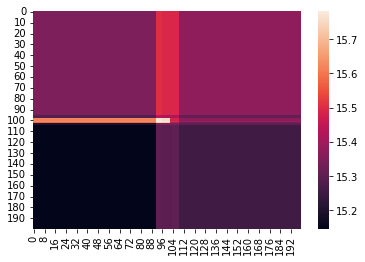

In [326]:
import seaborn as sns
fig, ax = plt.subplots()
# im = ax.imshow(lv)
ax = sns.heatmap(lv,)
plt.show()

In [202]:
state_next = np.reshape(state_next, [1, observation_space])
action = dqn_solver.act(state_next)
state_next, reward, terminal, info = env.step(action)
env.render()
reward, terminal, state_next

(1.0,
 False,
 array([ 0.00372083,  0.24386603,  0.04308591, -0.27942312], dtype=float32))

In [201]:
state_next = env.reset()

In [346]:
state_next

array([ 0.09413128,  0.43841866, -0.05099776, -0.5771346 ], dtype=float32)